# Getting Started with Trends API

This notebook serves as a tutorial for Trends endpoint in the Signal AI API.

Full technical documentation of the Trends endpoint is available here
https://api.signal-ai.com/docs#tag/Trends


## Trends API Overview

Trends API allows users to get aggregated data from the Signal AI Platform across different dimensions and with different metrics. It enables users to monitor, visualise and understand information such as the following:

- Changes in sentiment for an entity over time
- Sentiment for an entity in relation to a set of key topics
- News coverage and sentiment around an entity in different locations
- Difference in coverage and sentiment between entities over time and in relation to different topics

## 0. Setting things up!

### 0.1 Pre-requisites

Please make sure that you have familiarised yourself with the Signal AI API using the [Getting Started notebook](getting_started.ipynb)

In particular you would need to be able to use the following endpoints:

- Authentication: to be able to access the API
- Discovery: to be able to search for entities and topics of interest


Note: run `pip install -r requirements.txt` to install the dependencies for this notebook

In [2]:
import requests
import os
import pandas as pd
import json
from pandas.io.json import json_normalize

### 0.2 Check if authentication works!

You will need a client_id and client_secret to gain access to the API. The code below will assume they have been set and the environment variables `SIGNAL_API_CLIENT_ID` and `SIGNAL_API_CLIENT_SECRET` respectively.

Using your credentials you can request a temporary access token from the API using the url: https://api.signal-ai.com/auth/token


In [3]:
def authenticate(client_id, client_secret, url = "https://api.signal-ai.com"):
    """ obtain a temporary access token using user credentials """
    token_url = f'{url}/auth/token'
    payload = {
        "grant_type": "client_credentials",
        "client_id": client_id,
        "client_secret": client_secret
    }
    response = requests.post(token_url, data=payload)
    return response.json().get("access_token")

In [4]:
TEMP_ACCESS_TOKEN = authenticate(os.environ['SIGNAL_API_CLIENT_ID'], os.environ['SIGNAL_API_CLIENT_SECRET'])
if TEMP_ACCESS_TOKEN:
    print('Congratulations! You have an access token, it will last for 24 hours before you will need to reauthenticate by repeating this step')
else:
    print('Error: Perhaps the credentials are incorrect?')

Congratulations! You have an access token, it will last for 24 hours before you will need to reauthenticate by repeating this step


## Using Trends API

Before we start, let us define a request function that we can re-use across different example use cases.

In [5]:
def request(json=None):
    """ Make requests using a tempory access token """
    response = requests.post(
        'https://api.signal-ai.com/trends',
        json=json,
        headers={
            "Authorization": f'Bearer {TEMP_ACCESS_TOKEN}',
            "Content-Type": "application/json",
            # Since the endpoint is still private, this header is required:
            "X-Access": "private"
        },
    )
    return response


Following are some examples of the questions that can be answered using Trends API.

**Use case question**:

- How has the sentiment around my organisation been changing over time?

Note that you would need to have the ID of the entity as an input. For that please consult the [Getting Started notebook](getting_started.ipynb) to search for entities and obtain the ID of your chosen entity.




**Example**: Sentiment towards Wirecard between the beginning of March 2020 and the end of August 2020 in monthly intervals

In [6]:
entity_id = "eae834b7-5b2f-430e-99ce-770786a971cf" ##  ID for Wirecard

query = {
    # First we define the data to be included in the aggregation. 
    # This part of the query has got the same format as the query in the `Search` endpoint
    "where": {
        "published-at": {
            "gte": "2020-03-01",
            "lte": "2020-08-31"
        }
    },
    # Then we define how the data should be aggregated. 
    # Note the `include` field and how we specify the ID(s) of the entities we want the data to be grouped by.
    "aggregations": {
        "group-by": [
            {
                "dimension": "published-at",
                "interval": "month"
            },
            {
                "dimension": "entity",
                "include": [
                    entity_id
                ]
            },
            {
                "dimension": "entity.sentiment"
            }
        ],
        "metrics": ["document-count"]
    }
}

# Return the response in JSON format
wirecard_result = request(json=query).json()


You can see the structure of a typical Trends API response in a snippet of the response to the above query:

In [ ]:
{
    "aggregations": {
        "group-by": {
            "dimension": "published-at",
            "groups": [
                {
                    "group-by": {
                        "dimension": "entity",
                        "groups": [
                            {
                                "group-by": {
                                    "dimension": "entity.sentiment",
                                    "groups": [
                                        {
                                            "metrics": {
                                                "document-count": 457
                                            },
                                            "value": "negative"
                                        },
                                        {
                                            "metrics": {
                                                "document-count": 7179
                                            },
                                            "value": "neutral"
                                        },
                                        {
                                            "metrics": {
                                                "document-count": 3181
                                            },
                                            "value": "positive"
                                        }
                                    ]
                                },
                                "value": {
                                    "id": "eae834b7-5b2f-430e-99ce-770786a971cf",
                                    "name": "Wirecard",
                                    "type": "organisation"
                                }
                            }
                        ]
                    },
                    "value": "2020-03-01"
                    }]}}}


We can convert the result into a dataframe, for a better readability.

In [7]:
df = json_normalize(
        wirecard_result['aggregations']['group-by'],
        ['groups', 'group-by', 'groups', 'group-by', 'groups'],
        [['groups', 'value']],
        errors='ignore')

df = df.rename(columns={'value': 'Sentiment', 'metrics.document-count': 'Count', 'groups.value': 'Date'})
df = df.reindex(columns=['Date', 'Sentiment', 'Count'])

df.style.set_caption('Sentiment towards Wirecard')

,Date,Sentiment,Count
0,2020-03-01,negative,457
1,2020-03-01,neutral,7179
2,2020-03-01,positive,3181
3,2020-04-01,negative,1964
4,2020-04-01,neutral,9080
5,2020-04-01,positive,4177
6,2020-05-01,negative,2337
7,2020-05-01,neutral,9143
8,2020-05-01,positive,6994
9,2020-06-01,negative,23245


We can also plot the results to observe the temporal changes in sentiment

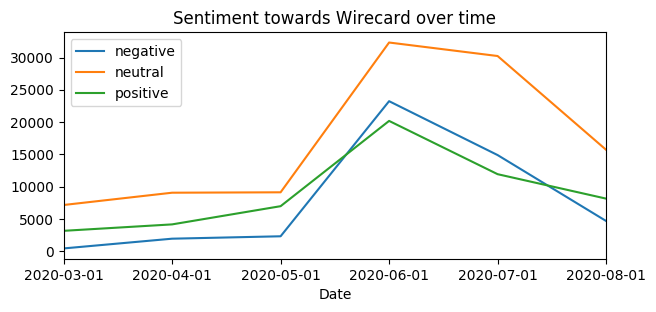

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=[7,3], dpi=100, facecolor='w')
ax1 = plt.subplot(111)
groupedby_sentiment = df.groupby('Sentiment')
plot = groupedby_sentiment.plot(kind='line', x='Date', y='Count', ax = ax1)
groups = [group for group,_ in groupedby_sentiment]
ax1.legend(groups)
_ = ax1.set_title('Sentiment towards Wirecard over time')

### 2. Sentiment for an entity in relation to a set of key topics

**Use case question**:

- How is sentiment towards organisations in my portfolio trending in relation to a set of key topics? 

**Example**: Sentiment trending around 7 car manufacturers in January 2021 and in relation to a set of 6 strategic topics

In [9]:
topics_ids = [
    "fc31abf2-7b11-4ed5-a7d2-35266057c0dd", 
    "c3e9ec2f-e225-4955-9dbf-5480ce3d30fe", 
    "a301b00d-f4ef-49fb-9224-f52386d4955e", 
    "fdcb69a5-8aa6-4067-a29b-f064321e1d7d", 
    "4249987d-5b02-4e51-9c44-019dd8e39742", 
    "8de14dc1-6a93-4d1f-b755-a8d7aa570187"
    ] ## IDs of the following topics: Innovation, Patents & Invention, Corporate Culture, Corporate Governance, Corporate Responsibility, Sustainability

entity_ids = [
    "d6341968-83df-441c-a869-fa7ae9c22c73", 
    "d7f0268d-1322-32b2-83d9-bb6fa9922506", 
    "a9cf01c5-751f-4fe5-a529-12e0d297cb63", 
    "c4ad0758-f3ee-4002-84aa-10849a153d75", 
    "06608104-0136-4371-ad04-be40fcc306a4", 
    "11cab8df-4be1-470f-8f49-8f7f0863ec95", 
    "946b44a8-b767-40ca-8093-e90d6af2a9d4"
    ] ##  IDs of the following car manufacturers: Toyota, Volkswagen, General Motors, Honda, BMW, Tesla, Ford

query = {
    "where": {
        "published-at": {
            "gte": "2021-01-01",
            "lte": "2021-01-31"
        }
    },
    "aggregations": {
        "group-by": [
            {
                "dimension": "published-at",
                "interval": "month"
            },
            # After grouping by month, we should first group by topics...
            {
                "dimension": "topic",
                "include": topics_ids
            },
            # ...then by entities
            {
                "dimension": "entity",
                "include": entity_ids
            },
            {
                "dimension": "entity.sentiment"
            }
        ],
        "metrics": ["document-count"]
    }
}

car_manufacturers_result = request(json=query).json()

In [10]:
df = json_normalize(
    car_manufacturers_result['aggregations']['group-by'],
    ['groups', 'group-by', 'groups', 'group-by', 'groups', 'group-by', 'groups'],
    [['groups', 'value'], 
     ['groups', 'group-by', 'groups', 'value'], 
     ['groups', 'group-by', 'groups', 'group-by', 'groups', 'value']],
    errors='ignore')

df = df.rename(columns={'value': 'Sentiment', 
                        'metrics.document-count': 'Count', 
                        'groups.value': 'Date', 
                        'groups.group-by.groups.value': 'Topic', 
                        'groups.group-by.groups.group-by.groups.value': 'Entity'})

df['Topic'] = df['Topic'].apply(lambda x: x['name'])
df['Entity'] = df['Entity'].apply(lambda x: x['name'])

df = df.reindex(columns=['Date', 'Topic', 'Entity', 'Sentiment', 'Count'])

# Take top 3 rows by document count for each topic 
df = df.sort_values('Count', ascending = False).groupby('Topic').head(3)

df.style.set_caption('Sentiment breakdown by car manufacturer and topic')

,Date,Topic,Entity,Sentiment,Count
44,2021-01-01,Sustainability,"Tesla, Inc.",positive,44003
5,2021-01-01,Innovation,"Tesla, Inc.",positive,21162
47,2021-01-01,Sustainability,General Motors,positive,19693
2,2021-01-01,Innovation,General Motors,positive,18603
8,2021-01-01,Innovation,Toyota,positive,17385
50,2021-01-01,Sustainability,BMW,positive,17064
68,2021-01-01,Corporate Responsibility,"Tesla, Inc.",positive,6974
22,2021-01-01,Corporate Governance,"Tesla, Inc.",neutral,5915
65,2021-01-01,Corporate Responsibility,General Motors,positive,4364
86,2021-01-01,Patents & Inventions,"Tesla, Inc.",positive,4154


### 3. News coverage and sentiment around an entity in different locations

**Use case question**:

- How do news coverage and sentiment around my agency’s clients vary across different countries?

**Example**: Coverage and sentiment around Uber in February 2021 and in 5 different countries

In [11]:
entity_id = "0c20f04a-94ef-467c-921d-f89f8895c41a" ##  ID for Uber
countries = [
    "United States", 
    "United Kingdom", 
    "Germany", 
    "France", 
    "Spain"
    ]

query = {
    "where": {
        "published-at": {
            "gte": "2021-02-01",
            "lte": "2021-02-28"
        },
        # Here we can narrow our search by selecting only the documents where Uber is mentioned
        "entities": {
            "id": {
                "eq": entity_id
            }
        }
    },
    "aggregations": {
        "group-by": [
            {
                "dimension": "source.country",
                "include": countries
            },
            {
                "dimension": "entity",
                "include": [
                    entity_id
                ]
            },
            {
                "dimension": "entity.sentiment"
            }
        ],
        "metrics": ["document-count"]
    }
}

uber_result = request(json=query).json()

In [12]:
df = json_normalize(
        uber_result['aggregations']['group-by'],
        ['groups', 'group-by', 'groups', 'group-by', 'groups'],
        [['groups', 'value']],
        errors='ignore')

df = df.rename(columns={'value': 'Sentiment', 'metrics.document-count': 'Count', 'groups.value': 'Country'})
df = df.reindex(columns=['Country', 'Sentiment', 'Count'])

df.style.set_caption('Sentiment towards Uber in February 2021')


,Country,Sentiment,Count
0,United States,negative,6644
1,United States,neutral,27508
2,United States,positive,18728
3,United Kingdom,negative,3420
4,United Kingdom,neutral,6322
5,United Kingdom,positive,2880
6,Germany,negative,769
7,Germany,neutral,1323
8,Germany,positive,1257
9,France,negative,490


### 4. Difference in coverage and sentiment between entities over time and in relation to different topics

**Use case question**:

- How do different organisations that I monitor compare with respect to coverage and sentiment in relation to key topics?

**Example**: Coverage and sentiment around 4 competitors in the mining industry in the second half of 2020 and in relation to 4 ESG topics

In [13]:
topics_ids = [
    "22297881-a936-4b51-a880-a7152c8ecc68",
    "ff9d1563-570f-4769-bbb5-7f3096beca0a",
    "8de14dc1-6a93-4d1f-b755-a8d7aa570187",
    "f8c74a1b-4f44-4a3f-b9bb-9b7cb221eb3f"
    ] ## IDs of the following topics: Environmental Cleanup, Corporate Controversy,  Sustainability, Chemicals

entity_ids = [
   "72800724-103f-4370-942a-0e715b58ee4a",
   "3d885924-a230-4fac-b17a-d5a1c1151cdf",
   "98eeff9c-6a9a-4d62-801d-eb94b240dd42",
   "592930e0-70fe-45f7-8a1e-ec504158dbf9"
    ] ##  IDs of the following mining companies: Rio Tinto, BHP, Glencore

query = {
    "where": {
        "published-at": {
            "gte": "2020-07-01",
            "lte": "2020-12-31"
        }
    },
    "aggregations": {
        "group-by": [
            {
                "dimension": "published-at",
                "interval": "month"
            },
            {
                "dimension": "topic",
                "include": topics_ids
            },
            {
                "dimension": "entity",
                "include": entity_ids
            },
            {
                "dimension": "entity.sentiment"
            }
        ],
        "metrics": ["document-count"]
    }
}

mining_companies_result = request(json=query).json()

In [14]:
df = json_normalize(
    mining_companies_result['aggregations']['group-by'],
    ['groups', 'group-by', 'groups', 'group-by', 'groups', 'group-by', 'groups'],
    [['groups', 'value'], 
     ['groups', 'group-by', 'groups', 'value'], 
     ['groups', 'group-by', 'groups', 'group-by', 'groups', 'value']],
    errors='ignore')

df = df.rename(columns={'value': 'Sentiment', 
                        'metrics.document-count': 'Count', 
                        'groups.value': 'Date', 
                        'groups.group-by.groups.value': 'Topic', 
                        'groups.group-by.groups.group-by.groups.value': 'Entity'})

df['Topic'] = df['Topic'].apply(lambda x: x['name'])
df['Entity'] = df['Entity'].apply(lambda x: x['name'])

df = df.reindex(columns=['Date', 'Topic', 'Entity', 'Sentiment', 'Count'])

# take top 5 rows by document count for each topic 
df = df.sort_values('Count',ascending = False).groupby('Topic').head(5)

df.style.set_caption('Sentiment breakdown by mining company and topic')

,Date,Topic,Entity,Sentiment,Count
26,2020-07-01,Chemicals,Rio Tinto Group,positive,3372
278,2020-12-01,Chemicals,Rio Tinto Group,positive,3339
28,2020-07-01,Chemicals,BHP,neutral,3224
133,2020-09-01,Chemicals,Rio Tinto Group,neutral,2986
277,2020-12-01,Chemicals,Rio Tinto Group,neutral,2946
96,2020-09-01,Corporate Controversy,Rio Tinto Group,negative,2641
97,2020-09-01,Corporate Controversy,Rio Tinto Group,neutral,1682
193,2020-11-01,Corporate Controversy,Rio Tinto Group,neutral,1242
241,2020-12-01,Corporate Controversy,Rio Tinto Group,neutral,1220
148,2020-10-01,Corporate Controversy,Rio Tinto Group,neutral,1151
